In [2]:
ReloadProject('deep_learning')

Path /workspace/external/deep_learning added to PYTHON_PATH.


Using TensorFlow backend.


notebook_init.py imported and reloaded
forwarded symbol: Activation
forwarded symbol: Dense
forwarded symbol: Dict
forwarded symbol: InputLayer
forwarded symbol: List
forwarded symbol: Model
forwarded symbol: Sequential
forwarded symbol: Tuple
reloaded: gym
forwarded symbol: gym
reloaded: keras
forwarded symbol: keras
reloaded: model_optimization
forwarded symbol: model_optimization
reloaded: openai_wrapper
forwarded symbol: openai_wrapper
reloaded: policy_impl
forwarded symbol: policy_impl
reloaded: q_function_memoization
forwarded symbol: q_function_memoization
reloaded: q_learning
forwarded symbol: q_learning
reloaded: q_learning_impl
forwarded symbol: q_learning_impl
reloaded: q_learning_impl_v2
forwarded symbol: q_learning_impl_v2
reloaded: q_learning_v2
forwarded symbol: q_learning_v2


## Introduction
A "policy" is a Keras model, whose `predict` on the environment variable decides the action. The idea is to use greedest decend method to perform policy iteration.

In [14]:
model = Sequential()
model.add(Dense(6, activation='relu', input_dim=4))
model.add(Dense(6, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_weight_manager = model_optimization.ModelWeightManager(model)

5

In [3]:
INPUT_SHAPE = (1, 4)

def GetPolicyValue(
    policy,  # Keras model
    env: openai_wrapper.GymEnvironment,
    num_simulations: int = 100,
    max_steps_in_simulation: int = 5000,
    print_values: bool = False,
) -> float:
    """Gets the potential value of a policy via simulation."""
    env.ChangeSettings(continue_from_done=False)
    values = []
    for _ in range(num_simulations):
        values.append(_GetValueFromOneSimulation(policy, env, max_steps_in_simulation))
    if print_values:
        print(values)
    return np.average(values)

def _GetValueFromOneSimulation(
    policy: np.ndarray,
    env: openai_wrapper.GymEnvironment,
    max_steps_in_simulation: int,
) -> int:
    """Gets the value of a policy using one simulaion."""
    env.Reset()
    reward = 0.0
    for _ in range(max_steps_in_simulation):
        state = env.GetState()
        try:
            reward += env.TakeAction(_DecideAction(policy, state))
        except openai_wrapper.OpenAiEnvironmentDone:
            break
    return reward
        
def _DecideAction(
    policy,  # Keras model
    state: np.ndarray,
) -> int:
    """Decides an action based on a policy and a state."""
    return policy.predict(np.reshape(state, INPUT_SHAPE)).argmax()

In [5]:
GetPolicyValue(model, openai_wrapper.GymEnvironment(gym.make('CartPole-v1')))

8.41

In [9]:
model = Sequential()
model.add(Dense(1, activation='relu', input_dim=4))
# model.add(Dense(6, activation='relu'))
# model.add(Dense(6, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

policy_param_manager = model_optimization.ModelWeightManager(model)

env = openai_wrapper.GymEnvironment(gym.make('CartPole-v1'))

def EvaluatePolicy(policy_parameters) -> float:
    policy_param_manager.SetWeights(policy_parameters)
    return -GetPolicyValue(policy_param_manager.model, env)

In [10]:
EvaluatePolicy(np.array(range(200)))

-8.33

In [11]:
from scipy import optimize
best_policy = np.array(optimize.fmin(EvaluatePolicy, policy_param_manager.GetWeights(), disp=True))
print('The best policy: %s, value: %s' % (best_policy, EvaluatePolicy(best_policy)))

The best policy: [-1.66264395e-05  1.00309526e+00  2.00862719e+00  3.08794079e+00
  4.01155326e+00  5.00358335e+00  5.94640496e+00  7.03019516e+00
  8.13450878e+00], value: -8.21


## Linear Model

In [4]:
model = Sequential()
model.add(Dense(1, activation='linear', input_dim=4))
model.compile(optimizer='sgd', loss='mse')

model_weight_manager = model_optimization.ModelWeightManager(model)
model_weight_manager.size

5

In [5]:
INPUT_SHAPE = (1, 4)

def GetPolicyValue(
    policy,  # Keras model
    env: openai_wrapper.GymEnvironment,
    num_simulations: int = 100,
    max_steps_in_simulation: int = 5000,
    print_values: bool = False,
) -> float:
    """Gets the potential value of a policy via simulation."""
    env.ChangeSettings(continue_from_done=False)
    values = []
    for _ in range(num_simulations):
        values.append(_GetValueFromOneSimulation(policy, env, max_steps_in_simulation))
    if print_values:
        print(values)
    return np.average(values)

def _GetValueFromOneSimulation(
    policy,  # Keras model
    env: openai_wrapper.GymEnvironment,
    max_steps_in_simulation: int,
) -> int:
    """Gets the value of a policy using one simulaion."""
    env.Reset()
    reward = 0.0
    for _ in range(max_steps_in_simulation):
        state = env.GetState()
        try:
            reward += env.TakeAction(_DecideAction(policy, state))
        except openai_wrapper.OpenAiEnvironmentDone:
            break
    return reward
        
def _DecideAction(
    policy,  # Keras model
    state: np.ndarray,
) -> int:
    """Decides an action based on a policy and a state."""
    action = 0 if policy.predict(np.reshape(state, INPUT_SHAPE)) < 0 else 1
#     print(state, action)
    return action

In [58]:
GetPolicyValue(model, openai_wrapper.GymEnvironment(gym.make('CartPole-v1')))

70.91

In [37]:
model = Sequential()
model.add(Dense(1, activation='linear', input_dim=4))
model.compile(optimizer='sgd', loss='mse')
policy_param_manager = model_optimization.ModelWeightManager(model)
env = openai_wrapper.GymEnvironment(gym.make('CartPole-v1'))

PLOT_EVERY_STEPS = 10

DEBUG_HISTORY = []
def EvaluatePolicy(policy_parameters) -> float:
    policy_param_manager.SetWeights(policy_parameters)
    score = -GetPolicyValue(policy_param_manager.model, env)
    DEBUG_HISTORY.append([policy_parameters, score])
    step = len(DEBUG_HISTORY)
    if step % PLOT_EVERY_STEPS == 0:
        display.clear_output(wait=True)
        print('%d: %s, %s' % (step, score, policy_parameters))
        y = [v[1] for v in DEBUG_HISTORY]
        x = range(step)
        plt.clf()
        plt.plot(x, y)
        display.display(plt.gcf())
    if score < -490:
        raise RuntimeError('score is good enough!')
    return score

In [69]:
EvaluatePolicy(policy_param_manager.GetWeights())

1: -8.29, [ 0.4615475   0.9871099  -0.23690563 -0.5939523   0.        ]


-8.29

In [72]:
from scipy import optimize

DEBUG_HISTORY = []
policy_param_manager.SetWeights(np.array([0.54217784, 0.46289368, 0.6995745, 0.73812184, 0.0]))
best_policy = np.array(optimize.fmin(EvaluatePolicy, policy_param_manager.GetWeights(), disp=True))
print('The best policy: %s, value: %s' % (best_policy, EvaluatePolicy(best_policy)))

1: -206.78, [0.54217786 0.46289369 0.69957447 0.73812187 0.        ]
2: -188.66, [0.56928675 0.46289369 0.69957447 0.73812187 0.        ]
3: -224.51, [0.54217786 0.48603838 0.69957447 0.73812187 0.        ]
4: -231.32, [0.54217786 0.46289369 0.73455319 0.73812187 0.        ]
5: -212.22, [0.54217786 0.46289369 0.69957447 0.77502796 0.        ]
6: -220.23, [5.42177856e-01 4.62893695e-01 6.99574471e-01 7.38121867e-01
 2.50000000e-04]
7: -252.4, [5.15068963e-01 4.72151569e-01 7.13565960e-01 7.52884305e-01
 1.00000000e-04]
8: -255.1, [4.87960070e-01 4.76780505e-01 7.20561705e-01 7.60265523e-01
 1.50000000e-04]
9: -243.21, [5.20490742e-01 4.77706293e-01 7.21960854e-01 7.61741767e-01
 1.60000000e-04]
10: -271.98, [5.11815896e-01 4.83631332e-01 7.30915407e-01 7.19521196e-01
 2.24000000e-04]
11: -304.62, [4.96634916e-01 4.94000151e-01 7.46585875e-01 6.91767814e-01
 3.36000000e-04]
12: -293.27, [4.93598720e-01 4.96073915e-01 7.49719969e-01 7.37885668e-01
 8.40000000e-06]
13: -355.68, [4.74167066

In [63]:
BEST_POLICY_VECTOR = [0.29429113, 0.55242426, 1.05572365, 1.27730287]

In [64]:
policy_param_manager.SetWeights(np.array([0.29429113, 0.55242426, 1.05572365, 1.27730287, 0.0]))
print(policy_param_manager.GetWeights())
EvaluatePolicy(policy_param_manager.GetWeights())

[0.29429114 0.55242425 1.0557237  1.2773029  0.        ]
1003: -499.0, [0.29429114 0.55242425 1.0557237  1.2773029  0.        ]


-499.0

In [65]:
policy_param_manager.SetWeights(np.array([0.98563711, 0.66429181, 0.78012283, 0.94977875, 0.0]))
print(policy_param_manager.GetWeights())
EvaluatePolicy(policy_param_manager.GetWeights())

[0.9856371  0.6642918  0.7801228  0.94977874 0.        ]
1004: -115.42, [0.9856371  0.6642918  0.7801228  0.94977874 0.        ]


-115.42

In [66]:
policy_param_manager.SetWeights(np.array([1.03491897, 0.66429181, 0.78012283, 0.94977875, 0.0]))
print(policy_param_manager.GetWeights())
EvaluatePolicy(policy_param_manager.GetWeights())

[1.034919   0.6642918  0.7801228  0.94977874 0.        ]
1005: -109.5, [1.034919   0.6642918  0.7801228  0.94977874 0.        ]


-109.5

In [67]:
policy_param_manager.SetWeights(np.array([0.98563711, 0.6975064, 0.78012283, 0.94977875, 0.0]))
print(policy_param_manager.GetWeights())
EvaluatePolicy(policy_param_manager.GetWeights())

[0.9856371  0.6975064  0.7801228  0.94977874 0.        ]
1006: -116.87, [0.9856371  0.6975064  0.7801228  0.94977874 0.        ]


-116.87

1000: -114.94, [ 1.19387182  0.00571772  0.68666377  1.28491647 -0.02227754]


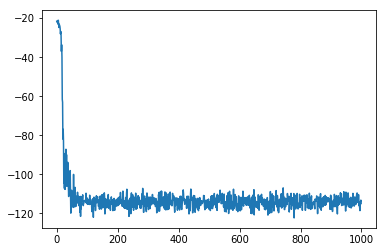

The best policy: [ 1.19387182  0.00571772  0.68666377  1.28491647 -0.02227754], value: -112.47
CPU times: user 1h 4min 53s, sys: 2min 3s, total: 1h 6min 57s
Wall time: 1h 7min 28s


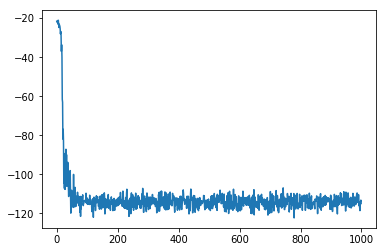

In [17]:
%%time

from scipy import optimize

DEBUG_HISTORY = []
policy_param_manager.SetWeights(np.random.rand(5))
best_policy = np.array(optimize.fmin(EvaluatePolicy, policy_param_manager.GetWeights(), disp=True))
print('The best policy: %s, value: %s' % (best_policy, EvaluatePolicy(best_policy)))

In [12]:
DEBUG_HISTORY

[[array([0.80258614, 0.39702812, 0.8928411 , 0.33042556, 0.3294172 ]), -8.57],
 [array([0.84271545, 0.39702812, 0.8928411 , 0.33042556, 0.3294172 ]), -8.34],
 [array([0.80258614, 0.41687952, 0.8928411 , 0.33042556, 0.3294172 ]), -8.4],
 [array([0.80258614, 0.39702812, 0.93748316, 0.33042556, 0.3294172 ]), -8.45],
 [array([0.80258614, 0.39702812, 0.8928411 , 0.34694684, 0.3294172 ]), -8.91],
 [array([0.80258614, 0.39702812, 0.8928411 , 0.33042556, 0.34588806]), -8.45],
 [array([0.76245683, 0.40496868, 0.91069792, 0.33703407, 0.33600554]), -8.44],
 [array([0.78653442, 0.38035294, 0.91784065, 0.33967748, 0.33864088]), -9.1],
 [array([0.77850855, 0.36208964, 0.93034043, 0.34430343, 0.34325272]), -9.84],
 [array([0.83308441, 0.37511217, 0.90784083, 0.33597671, 0.33495141]), -8.87],
 [array([0.80515441, 0.37428635, 0.93169755, 0.34480568, 0.32069423]), -9.97],
 [array([0.80643855, 0.36291546, 0.95112577, 0.35199574, 0.30809732]), -10.49],
 [array([0.80669538, 0.36064129, 0.89251254, 0.353433

110: -499.0, [0.31032994 0.1778262  1.45710001 0.6782369  0.13963591]


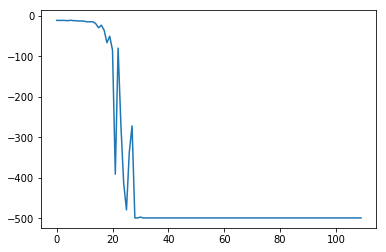

Optimization terminated successfully.
         Current function value: -499.000000
         Iterations: 35
         Function evaluations: 114
The best policy: [0.31033061 0.1777982  1.4571873  0.67825362 0.13961084], value: -499.0
CPU times: user 28min 15s, sys: 56.3 s, total: 29min 11s
Wall time: 29min 23s


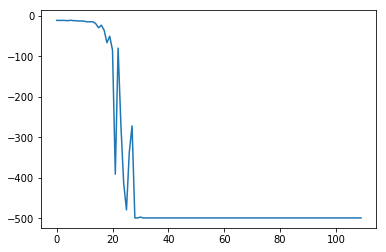

In [18]:
%%time

from scipy import optimize

DEBUG_HISTORY = []
policy_param_manager.SetWeights(np.random.rand(5))
best_policy = np.array(optimize.fmin(EvaluatePolicy, policy_param_manager.GetWeights(), disp=True))
print('The best policy: %s, value: %s' % (best_policy, EvaluatePolicy(best_policy)))

## Try some variation

In [33]:
model = Sequential()
model.add(Dense(1, activation='relu', input_dim=4))
model.compile(optimizer='sgd', loss='mse')

policy_param_manager = model_optimization.ModelWeightManager(model)
policy_param_manager.size

5

In [27]:
INPUT_SHAPE = (1, 4)

def GetPolicyValue(
    policy,  # Keras model
    env: openai_wrapper.GymEnvironment,
    num_simulations: int = 100,
    max_steps_in_simulation: int = 5000,
    print_values: bool = False,
) -> float:
    """Gets the potential value of a policy via simulation."""
    env.ChangeSettings(continue_from_done=False)
    values = []
    for _ in range(num_simulations):
        values.append(_GetValueFromOneSimulation(policy, env, max_steps_in_simulation))
    if print_values:
        print(values)
    return np.average(values)

def _GetValueFromOneSimulation(
    policy,  # Keras model
    env: openai_wrapper.GymEnvironment,
    max_steps_in_simulation: int,
) -> int:
    """Gets the value of a policy using one simulaion."""
    env.Reset()
    reward = 0.0
    for _ in range(max_steps_in_simulation):
        state = env.GetState()
        try:
            reward += env.TakeAction(_DecideAction(policy, state))
        except openai_wrapper.OpenAiEnvironmentDone:
            break
    return reward
        
def _DecideAction(
    policy,  # Keras model
    state: np.ndarray,
) -> int:
    """Decides an action based on a policy and a state."""
    action = 0 if policy.predict(np.reshape(state, INPUT_SHAPE)) < 0.5 else 1
#     print(state, action)
    return action

90: -499.0, [0.24761516 0.45994614 1.03090574 1.26229877 0.50688837]


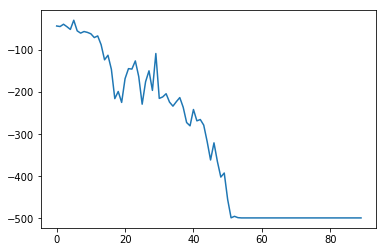

KeyboardInterrupt: 

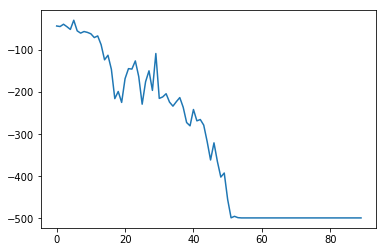

In [34]:
%%time

from scipy import optimize

DEBUG_HISTORY = []
policy_param_manager.SetWeights(np.random.rand(5))
best_policy = np.array(optimize.fmin(EvaluatePolicy, policy_param_manager.GetWeights(), disp=True))
print('The best policy: %s, value: %s' % (best_policy, EvaluatePolicy(best_policy)))

In [48]:
model = Sequential()
model.add(Dense(4, activation='relu', input_dim=4))
# model.add(Dense(4, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='sgd', loss='mse')

policy_param_manager = model_optimization.ModelWeightManager(model)
policy_param_manager.size

def _DecideAction(
    policy,  # Keras model
    state: np.ndarray,
) -> int:
    """Decides an action based on a policy and a state."""
    action = 0 if policy.predict(np.reshape(state, INPUT_SHAPE)) < 0 else 1
#     print(state, action)
    return action

5000: -8.39, [0.98042855 0.03478885 0.51961999 0.24016231 0.78489583 0.17929266
 0.96530212 0.99037512 0.05176838 0.85168293 0.82549015 0.31448236
 0.55310239 0.13176736 0.8747356  0.84772408 0.59373501 0.55790035
 0.19717097 0.25536493 0.52288754 0.29343462 0.44819501 0.21914162
 0.01953841]


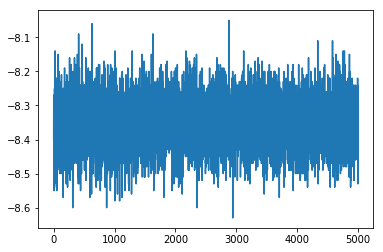

The best policy: [0.98042855 0.03478885 0.51961999 0.24016231 0.78489583 0.17929266
 0.96530212 0.99037512 0.05176838 0.85168293 0.82549015 0.31448236
 0.55310239 0.13176736 0.8747356  0.84772408 0.59373501 0.55790035
 0.19717097 0.25536493 0.52288754 0.29343462 0.44819501 0.21914162
 0.01953841], value: -8.28
CPU times: user 32min 46s, sys: 50.7 s, total: 33min 37s
Wall time: 33min 53s


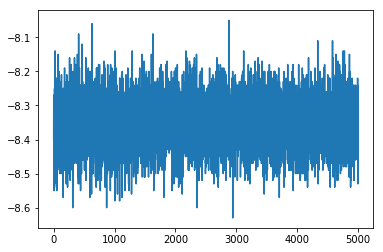

In [51]:
%%time

from scipy import optimize

DEBUG_HISTORY = []
policy_param_manager.SetWeights(np.random.rand(policy_param_manager.size))
best_policy = np.array(optimize.fmin(EvaluatePolicy, policy_param_manager.GetWeights(), disp=True))
print('The best policy: %s, value: %s' % (best_policy, EvaluatePolicy(best_policy)))